## Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# lib manipulation data
import pandas as pd

# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Akuisisi Data

In [3]:
# load dataset
dataset = data_hotspot()
print(dataset.tail())

      acq_date  hotspot
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42


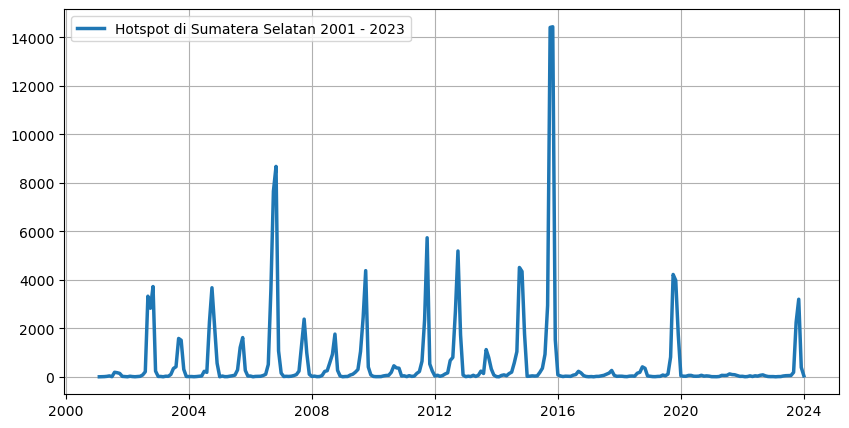

In [4]:
# hasil load dataset
lineplot1(dataset["acq_date"], dataset["hotspot"], "Hotspot di Sumatera Selatan 2001 - 2023")

### 2. Praproses Data

In [5]:
# proses normalisasi min-max
scaled = normalized(dataset, ["hotspot"])

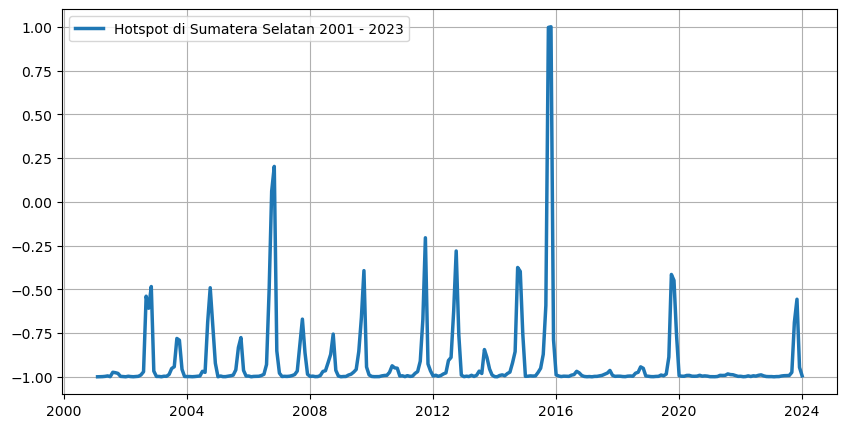

In [6]:
# hasil normalisasi min-max
lineplot1(dataset["acq_date"], np.array(scaled), "Hotspot di Sumatera Selatan 2001 - 2023")

### 3. Pembagian Data

In [7]:
# proses pembagian data
train_data, test_data = splitting(scaled)

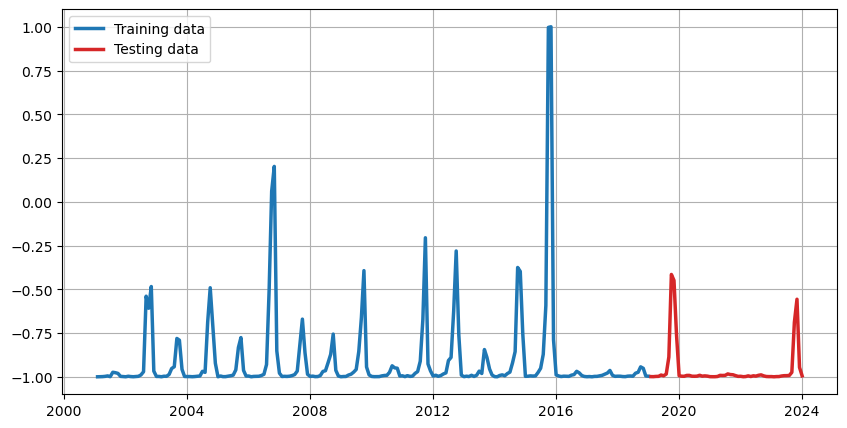

In [8]:
# hasil pembagian data
lineplot2(
  x1=dataset.iloc[0:len(train_data),0], y1=train_data, label1="Training data",
  x2=dataset.iloc[len(train_data):len(dataset),0], y2=test_data, label2="Testing data",
)

### 4. Supervised Learning

In [9]:
# function for supervised learning
x_train, y_train, x_test, y_test = results_supervised_learning(train_data, test_data)

In [10]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(215, 1, 1) (215,)


In [11]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 1) (59,)


### 5.1 Modeling SBi-LSTM

In [12]:
# call models LSTM
model = get_lstm(
  timestep=x_train.shape[1],
  activation="selu",
  dropout=0.25,
  optimizer="sgd"
)

In [13]:
# compile models
history, predictions = get_predictions(
  model=model,
  x_train=x_train, y_train=y_train,
  x_test=x_test, y_test=y_test,
  batch_size=8, epochs=1500
)

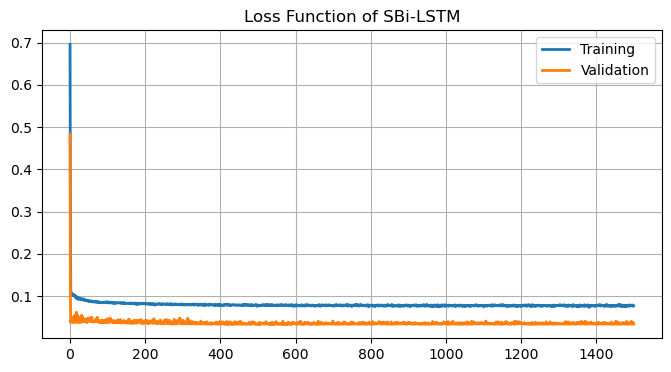

In [14]:
# show loss function
lineplot3(
  training=history.history['loss'],
  validation=history.history['val_loss'],
  title="Loss Function of SBi-LSTM"
)

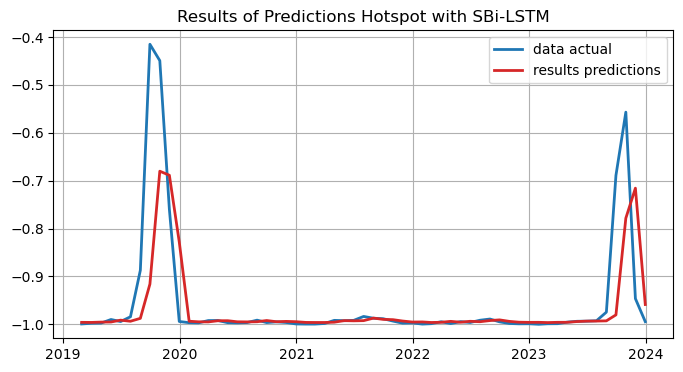

In [15]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=y_test,
  ypred=predictions,
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [16]:
from xgboost import XGBRegressor

In [17]:
residuals = y_test - predictions[:, 0]

In [18]:
# Train XGBoost model on residuals
xgb_model = xgb.XGBRegressor()
xgb_model.fit(np.vstack(x_test), residuals)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# Predict residuals with XGBoost model
xgb_predictions = xgb_model.predict(np.vstack(x_test))

In [20]:

# Combine LSTM and XGBoost predictions
boosted_predictions = predictions[:, 0] + xgb_predictions

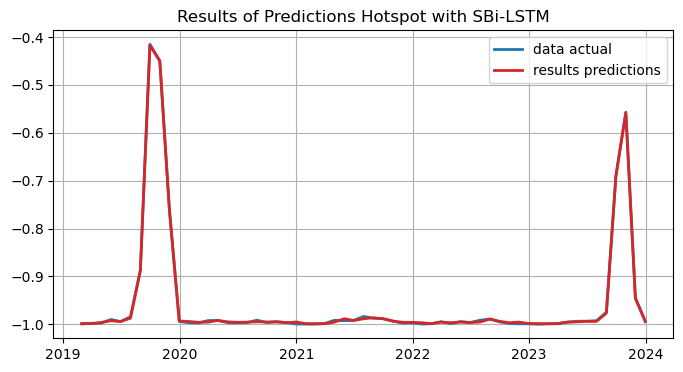

In [21]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=y_test,
  ypred=boosted_predictions,
  title="Results of Predictions Hotspot with SBi-LSTM"
)